In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Define your work path ###
work_path = '/content/drive/MyDrive/'

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [ ]:
#File Path
file_path = work_path+'Dataset_sj.csv'
df = pd.read_csv(file_path)

# Select relevant features and target variable
features = ['SW38', 'SW38_C', 'SW38-IR105', 'SW38-IR105_C', 'NR13', 'NR13_C', 'SOZ']
target = 'Isfire'

In [ ]:
# Filter the dataset for the selected casenum values
train_data = df[df['Casenum'].isin([124, 130])]
test_data = df[df['Casenum'].isin([119, 151])]

# Separate features and target variable
X_train = train_data[features].values
y_train = train_data[target].values
X_test = test_data[features].values
y_test = test_data[target].values

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Reshape the features for 1D CNN input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
#1D CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))  # Adding dropout
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Adding dropout
model.add(Dense(1, activation='sigmoid'))

In [ ]:
#learning rate
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
419/419 [==============================] - 6s 9ms/step - loss: 0.0115 - accuracy: 0.9963 - val_loss: 0.2707 - val_accuracy: 0.9746
Epoch 2/20
419/419 [==============================] - 2s 4ms/step - loss: 0.0127 - accuracy: 0.9960 - val_loss: 0.1937 - val_accuracy: 0.9768
Epoch 3/20
419/419 [==============================] - 2s 4ms/step - loss: 0.0106 - accuracy: 0.9966 - val_loss: 0.2470 - val_accuracy: 0.9743
Epoch 4/20
419/419 [==============================] - 2s 4ms/step - loss: 0.0136 - accuracy: 0.9960 - val_loss: 0.3289 - val_accuracy: 0.9733
Epoch 5/20
419/419 [==============================] - 2s 6ms/step - loss: 0.0096 - accuracy: 0.9969 - val_loss: 0.2716 - val_accuracy: 0.9743
Epoch 6/20
419/419 [==============================] - 2s 6ms/step - loss: 0.0102 - accuracy: 0.9972 - val_loss: 0.3006 - val_accuracy: 0.9733
Epoch 7/20
419/419 [==============================] - 2s 4ms/step - loss: 0.0107 - accuracy: 0.9968 - val_loss: 0.2568 - val_accuracy: 0.9746
Epoch 

In [ ]:
# model evaluation on the test data
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")

128/128 [==============================] - 0s 2ms/step
Test Accuracy: 0.973330070956692


In [ ]:
# DataFrame with predictions, features, Lat, and Lon
results_df = pd.DataFrame(np.concatenate([X_test.reshape(X_test.shape[0], -1), y_pred, df.loc[test_data.index, ['Lat', 'Lon', 'Casenum','Year','Month','Day','Hour','Minute']]], axis=1),
                           columns=[f'Feature_{i}' for i in range(X_test.shape[1])] + ['Predicted_IsFire', 'Lat', 'Lon', 'Casenum','Year','Month','Day','Hour','Minute'])

#'Isfire' column before any modifications
isfire_column = test_data['Isfire'].values

# Add 'Isfire' column from the original data
results_df['Isfire'] = isfire_column


# Save a CSV file
results_df.to_csv(work_path+'predictions_with_coordinates.csv', index=False)


In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[3705    2]
 [  73  307]]


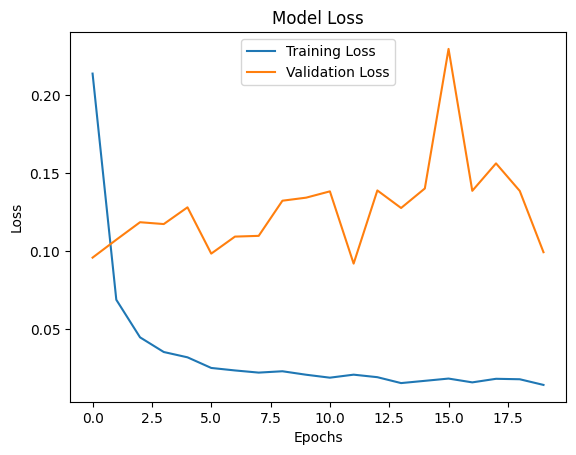

In [ ]:
# Visualize Model Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

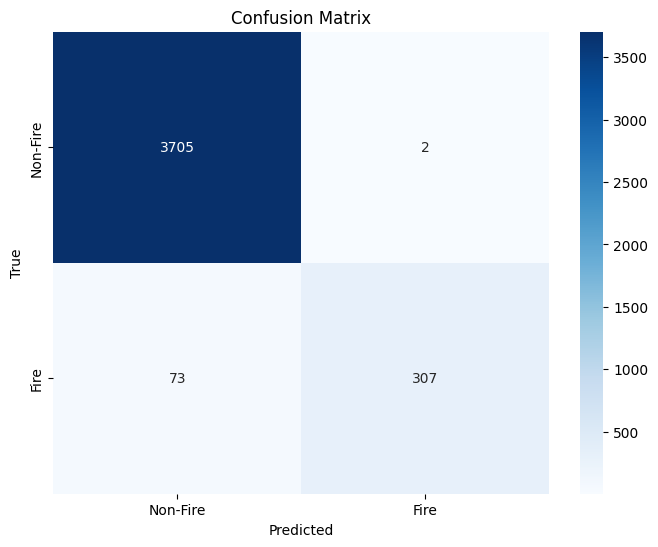

In [ ]:
import seaborn as sns
# Plot the confusion matrix
labels = ['Non-Fire', 'Fire']
df_cm = pd.DataFrame(conf_matrix, index=labels, columns=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')
plt.show()

In [ ]:
import pandas as pd

df_new = pd.read_csv(work_path+'predictions_with_coordinates.csv')

# new column based on conditions
df_new['New'] = df_new['Isfire'] * 2 + df_new['Predicted_IsFire'] + 1

print(df)
df_new.to_csv(work_path+'predictions_with_coordinates_new.csv', index=False)


        Isfire  Isvali  Casenum  Year  Month  Day  Hour  Minute       Lat  \
0            0       0        3  2020      1    4     5       8  33.42660   
1            0       0        3  2020      1    4     5       8  35.66608   
2            0       0        3  2020      1    4     5       8  35.72326   
3            0       0        3  2020      1    4     5       8  35.73622   
4            0       0        3  2020      1    4     5       8  35.87545   
...        ...     ...      ...   ...    ...  ...   ...     ...       ...   
377860       1       1      190  2022      5   31    14      16  35.55391   
377861       1       1      190  2022      5   31    14      18  35.53553   
377862       1       1      190  2022      5   31    14      22  35.55454   
377863       1       1      190  2022      5   31    14      24  35.53553   
377864       1       1      190  2022      5   31    14      24  35.55391   

              Lon  ...  SW38-IR112_C  SW38-IR123_C  SW38-IR133_C  \
0      